<a href="https://colab.research.google.com/github/FedericaParlapiano/Sentiment-Analysis-ChatGPT-reviews/blob/main/Fine_Tuning_BERT_ChatGPTReviews16_2_balanced_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Fine-Tuning BERT per classificazione di testo**

### Import delle librerie necessarie

In [3]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
import nltk
import re
from tabulate import tabulate
from tqdm import trange

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

In [4]:


#verificare la disponibilità di cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(torch.cuda.get_device_name(0))
print(device)

Tesla T4
cuda:0



## Lettura dei dati

In [5]:
# connettere Colab a Drive per caricare un dataset
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

# lettura del file
df = pd.read_csv("/content/gdrive/MyDrive/BERT/file.csv", index_col=0)
df.head()

Mounted at /content/gdrive/


,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [6]:
# conteggio elementi per ogni label
from collections import Counter
Counter(df.labels)

Counter({'neutral': 55487, 'good': 56011, 'bad': 107796})

In [7]:
#df = df.groupby(by='labels', group_keys=False).apply(lambda x: x.sample(55487, replace=True))

In [8]:
df

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad
...,...,...
219289,Other Software Projects Are Now Trying to Repl...,bad
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,good
219291,chatgpt is being disassembled until it can onl...,bad
219292,2023 predictions by #chatGPT. Nothing really s...,bad


## Pre-processing dei dati

In [9]:
# mapping delle label
df['labels'] = df.labels.map({'neutral':0,'good':1,'bad':2})

In [10]:
# rimozione dei tweet duplicati
df = df.drop_duplicates(subset=['tweets'])

In [11]:
Counter(df.labels)

Counter({0: 55174, 1: 55754, 2: 106694})

In [12]:
df = df.groupby(by='labels', group_keys=False).apply(lambda x: x.sample(55174, replace=True))

In [13]:
random_state = 42

def shuffle(df, n=3, axis=0):
    df = df.copy()
    for i in range(n):
        df = df.sample(frac=1,random_state=random_state) # mischio il dataframe
    return df

df = shuffle(df)
df

,tweets,labels
64357,I asked #ChatGPT and @copy_ai what they though...,2
4160,PoC doesn't work. The AI has just blindly copi...,0
25771,"Show HN: GPTLang, a New Programming Language I...",2
197551,Have you ever wondered why U.S. professional b...,1
45099,Asking ChatGPT what the brightest star in Orio...,1
...,...,...
208089,I'm 2006 Google Web Search felt like magic. Ki...,1
92410,"yes u can chat with chatgpt , its fun but does...",1
65635,First one I have found so far that has a signi...,0
47291,Well #ChatGPT can write #kql queries and also ...,0


In [14]:
Counter(df.labels)

Counter({2: 55174, 0: 55174, 1: 55174})

### Rimozione stopwords

In [15]:
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('english')

# rimozione line break
text = []
for d in df['tweets']:
  text.append(d.replace("\\n",""))
df['tweets'] = text

def clean_text(text):

    # testo in minuscolo
    text = text.lower()

    # regex per la sostituzione di ogni carattere tranne (a-z, A-Z, ".", "?", "!", ",")
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ",text)

    # regex per la sostituzione dei link https
    text = re.sub(r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)", " ", text, flags=re.MULTILINE)
    text = re.sub(r"https", "", text)

    # regex per la sostituzione dei tag html
    html = re.compile(r'<.*?>')
    text = html.sub(r'', text)

    # rimozione della punteggiatura
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^,' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p, '')

    # rimozione stopwords
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    text = " ".join(text)

    # regex per la sostituzione di emoji pattern
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticon
                               u"\U0001F300-\U0001F5FF"  # simboli e pittogrammi
                               u"\U0001F680-\U0001F6FF"  # simboli geogafici
                               u"\U0001F1E0-\U0001F1FF"  # flag (iOS)
                               u"\U00002500-\U00002BEF"  # caratteri cinesi
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
df['tweets'] = df['tweets'].apply(lambda x: clean_text(x))

# dataframe processato
df['tweets']

64357     asked chatgpt copy ai thought google thinks ai...
4160      poc work ai blindly copied payload internet wi...
25771     show hn gptlang new programming language imple...
197551    ever wondered explain assist sophisticated art...
45099     asking chatgpt brightest star orion switches a...
                                ...                        
208089    google web search felt like magic kinda like c...
92410     yes u chat chatgpt fun help daily worklife sem...
65635                  first one found far significant load
47291      well chatgpt write kql queries also msticpy code
12425     asked chatgpt arguments eliminative theory con...
Name: tweets, Length: 165522, dtype: object

### Train Test Split

In [17]:
# split dei dati secondo il rapporto 80-20
split_idx = int(len(df)*0.8)

train_df = df.iloc[:split_idx,:]
test_df = df.iloc[split_idx:,:]
print('train lenght:',len(train_df))
print(train_df.groupby(['labels'])['tweets'].count())
print('test lenght:',len(test_df))
print(test_df.groupby(['labels'])['tweets'].count())

train lenght: 132417
labels
0    44172
1    44137
2    44108
Name: tweets, dtype: int64
test lenght: 33105
labels
0    11002
1    11037
2    11066
Name: tweets, dtype: int64


In [18]:
sentences = train_df.tweets
labels = list(train_df.labels)

### Tokenizzazione

In [19]:
# creazione del tokenizer a partire dal modello bert-base-uncased
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

#### Esempio di tokenizzazione di un tweet

In [20]:
index=0
print('Tweet: ', list(sentences)[index])
print('Tokenized: ', tokenizer.tokenize(list(sentences)[index])) # split in token

table = np.array([tokenizer.tokenize(list(sentences)[index]),
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(list(sentences)[index]))]).T
print(tabulate(table,headers = ['Tokens', 'Token IDs'],tablefmt = 'fancy_grid'))

Tweet:  asked chatgpt copy ai thought google thinks ai contenthere said
Tokenized:  ['asked', 'chat', '##gp', '##t', 'copy', 'ai', 'thought', 'google', 'thinks', 'ai', 'content', '##her', '##e', 'said']
╒══════════╤═════════════╕
│ Tokens   │   Token IDs │
╞══════════╪═════════════╡
│ asked    │        2356 │
├──────────┼─────────────┤
│ chat     │       11834 │
├──────────┼─────────────┤
│ ##gp     │       21600 │
├──────────┼─────────────┤
│ ##t      │        2102 │
├──────────┼─────────────┤
│ copy     │        6100 │
├──────────┼─────────────┤
│ ai       │        9932 │
├──────────┼─────────────┤
│ thought  │        2245 │
├──────────┼─────────────┤
│ google   │        8224 │
├──────────┼─────────────┤
│ thinks   │        6732 │
├──────────┼─────────────┤
│ ai       │        9932 │
├──────────┼─────────────┤
│ content  │        4180 │
├──────────┼─────────────┤
│ ##her    │        5886 │
├──────────┼─────────────┤
│ ##e      │        2063 │
├──────────┼─────────────┤
│ said     │  

### Token encoding

In [21]:
max_len = 0
l=[]

for sent in list(sentences):

    # tokenizzazione di una frase e aggiunta dei token [CLS] e [SEP]
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    l.append(len(input_ids))
    # aggiornamento della varibile relativa alla lunghzza massima di una frase
    max_len = max(max_len, len(input_ids))

# lunghezza media delle frasi
avg_len=int(sum(l)/len(l))

print('Lunghezza massima di un tweet: ', max_len)
print('Lunghezza media dei tweet: ', avg_len)

Lunghezza massima di un tweet:  84
Lunghezza media dei tweet:  18


In [22]:
input_ids = []
attention_masks = []

for sent in sentences:
    # `encode_plus` step:
    #   (1) si tokenizza la fase
    #   (2) si appende un token [CLS] in testa al primo token
    #   (3) si appende un token [SEP] in coda all'ultimo token
    #   (4) mapping di ciascun token al rispettivo word id
    #   (5) si aggiunge eventuale padding alla frase fino alla lunghezza specificata come attributo max_length
    #   (6) si crea un attention masks per i token [PAD]
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = max_len,
                        truncation = True,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',     # return pytorch tensor
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# converione della lista delle frasi processate in un oggetto tensor
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [23]:
labels
attention_masks

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

#### Esempio di Encoding

In [24]:
print('Tweet: ', list(sentences)[index])
print('Input IDs:', input_ids[index])

Tweet:  asked chatgpt copy ai thought google thinks ai contenthere said
Input IDs: tensor([  101,  2356, 11834, 21600,  2102,  6100,  9932,  2245,  8224,  6732,
         9932,  4180,  5886,  2063,  2056,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [25]:
# Visualizzazione dei token, dei token IDs e dell'attention mask per la frase con indice specificato
def print_rand_sentence_encoding():
  tokens = tokenizer.tokenize(tokenizer.decode(input_ids[index]))
  token_ids = [i.numpy() for i in input_ids[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(list(sentences)[index])
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

asked chatgpt copy ai thought google thinks ai contenthere said
╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │         101 │                1 │
├──────────┼─────────────┼──────────────────┤
│ asked    │        2356 │                1 │
├──────────┼─────────────┼──────────────────┤
│ chat     │       11834 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##gp     │       21600 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##t      │        2102 │                1 │
├──────────┼─────────────┼──────────────────┤
│ copy     │        6100 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ai       │        9932 │                1 │
├──────────┼─────────────┼──────────────────┤
│ thought  │        2245 │                1 │
├──────────┼─────────────┼──────────────────┤
│ google   │        8224 │                1 │
├──────────┼────

## Modellazione

### Train Validation Split

In [26]:
# creazione di un TensorDataset a partire dai dati del training set
dataset = TensorDataset(input_ids, attention_masks, labels)

# 80-20 train-validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# division del dataset (selezione random di quali sample mettere in uno e nell'altro set)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training sample'.format(train_size))
print('{:>5,} validation sample'.format(val_size))

105,933 training sample
26,484 validation sample


### Parametri di train
I valori considerati ricadono nei seguente intervalli:

- Batch size: 16, 32
- Learning rate (Adam optimizer): 2e-5
- Numero di epoche: 2, 3, 4

In [27]:
batch_size = 16

# creazione di un DataLoaders per il training set
train_dataloader = DataLoader(
            train_dataset,  # training samples
            sampler = RandomSampler(train_dataset), # inserimento randomico
            batch_size = batch_size # batch size
        )

# creazione di un DataLoaders per il training set e per il validation set
# in questo caso non interessa che i dati siano selezinati randomicamente
validation_dataloader = DataLoader(
            val_dataset, # validation samples
            sampler = SequentialSampler(val_dataset), # inserimento sequenziale
            batch_size = batch_size # batch size
        )

### Creazione del modello BERT

In [28]:
# modello pre-addestrato BertForSequenceClassification
# https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # modello BERT con 12-layer e un vocabolario no casesesitive
    num_labels = 3, # numero delle classi (label)
    output_attentions = False,
    output_hidden_states = False,
)

model = model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Fine tuning del modello

In [30]:
epochs = 2

# numero di step pari al prodotto [numero di batch] x [numero di epoche] (diverso dal numero di sample nel training set)
total_steps = len(train_dataloader) * epochs

# creazione dello scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [31]:
# funzione per calcolare l'accuratezza delle predizioni
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# funzione per formattare il tempo di ogni epoca
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [32]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    t0 = time.time()
    total_train_loss = 0

    # configurazionde del modello nella modalità di training (non esegue effettivamente il training ma specifica solo il modo in cui avviene)
    model.train()

    for step, batch in enumerate(train_dataloader):
        # `batch` contiene tre tensori pytorch
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        loss = output.loss
        logits = output.logits
        total_train_loss += loss.item()
        # backward pass per il calcolo del gradiente dei pesi
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # aggiornamento dei pesi del modello in base al gradiente calcolato
        optimizer.step()
        # aggiornamento del learning rate
        scheduler.step()

    # loss media dei batch
    avg_train_loss = total_train_loss / len(train_dataloader)

    # tempo per il completamento di un epoca
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")

    t0 = time.time()

    # configurazionde del modello nella modalità di validazione (non esegue effettivamente la validazione ma specifica solo il modo in cui avviene)
    model.eval()

    total_eval_accuracy = 0
    best_eval_accuracy = np.Inf
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        # `batch` contiene tre tensori pytorch
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()

        # spostamento alla CPU se si sta usando la GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # calcolo dell'accuratezza totale per tutti i batch di una epoca
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # accuratezza media dei batch
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # loss media dei batch
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # tempo per il completamento di un epoca
    validation_time = format_time(time.time() - t0)

    # salvtaggio del modello migliore
    if avg_val_accuracy < best_eval_accuracy:
        torch.save(model, 'bert_model_chatGPT')
        best_eval_accuracy = avg_val_accuracy

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # statistiche sull'epoca
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.48
  Training epcoh took: 0:27:44

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.38
  Validation took: 0:02:27

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.32
  Training epcoh took: 0:27:52

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.35
  Validation took: 0:02:27

Training complete!
Total training took 1:00:36 (h:mm:ss)


## Statistiche di training

In [33]:
import pandas as pd

pd.set_option('display.precision', 2)

# creazione di un dataframe a partire dalla lista delle statistiche sul training del modello
df_stats = pd.DataFrame(data=training_stats)
# indice di riga pari all'epoca
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.48,0.38,0.87,0:27:44,0:02:27
2,0.32,0.35,0.90,0:27:52,0:02:27


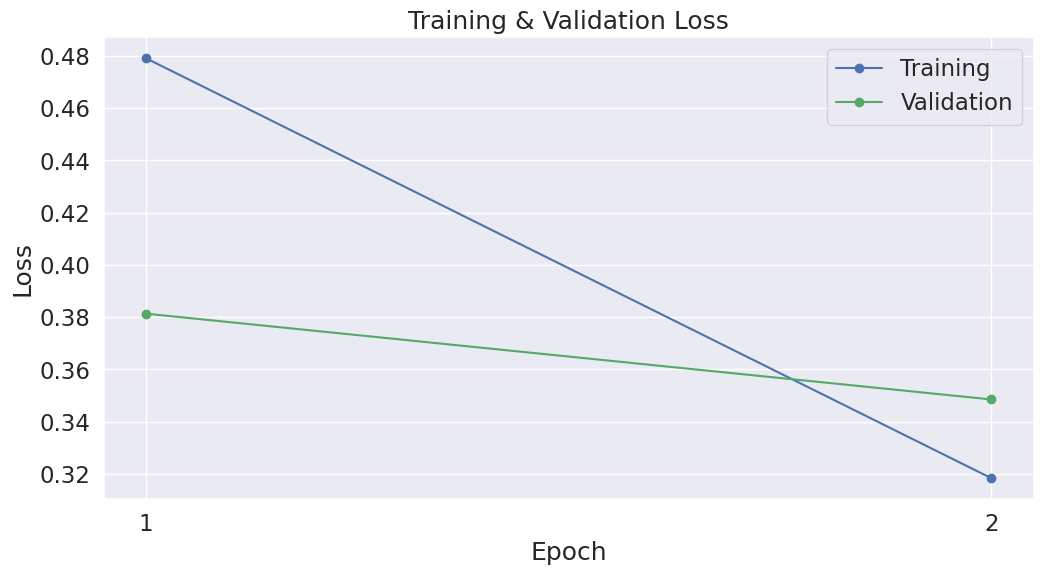

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# plot della curva di loss per training e per validation
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2])

plt.savefig("/content/gdrive/MyDrive/BERT/loss.png", bbox_inches="tight")
plt.show()

## Caricamento del modello migliore

In [35]:
model = torch.load('bert_model_chatGPT')

## Test performance

In [36]:
sentences = test_df.tweets.values
labels = test_df.labels.values

input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )


    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 16

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [37]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

model.eval()
predictions , true_labels = [], []

# predizione
for batch in prediction_dataloader:
    # aggiunta del batch alla GPU
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    # indicazione al modello per far sì che non calcoli e non memorizzi il gradiente
    with torch.no_grad():
      # forward pass
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # predizione e true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 33,105 test sentences...
    DONE.


In [38]:
from functools import reduce
scores = reduce(lambda x,y: x+y,[list(map(np.argmax,p)) for p in predictions])
labels = reduce(lambda x,y: list(x) + list(y), true_labels)

# calcolo dell'accuratezza
from sklearn.metrics import accuracy_score
accuracy_score(scores, labels)

0.8937018577254191



### Matrice di confusione

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import itertools


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("/content/gdrive/MyDrive/BERT/confusionmatrix.png", bbox_inches="tight")
    plt.show()

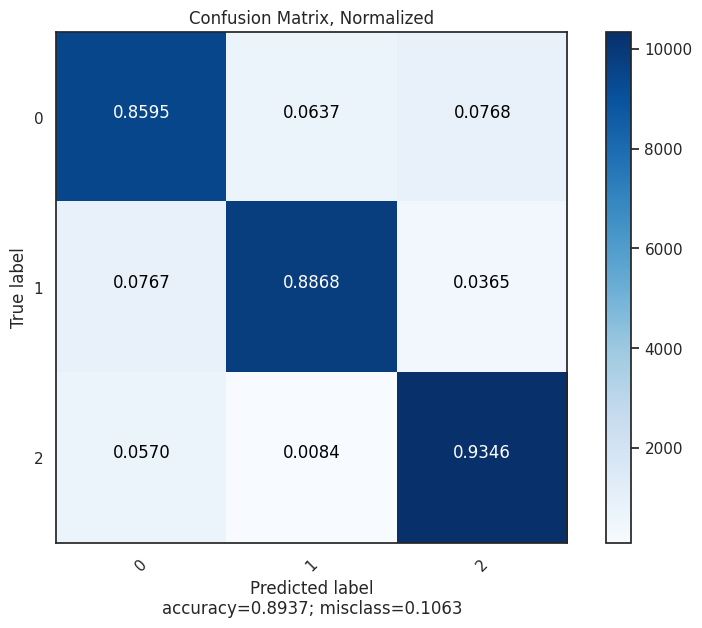

In [40]:
from sklearn.metrics import confusion_matrix

sns.set(font_scale=1)
sns.set(style='white')


cm = confusion_matrix(labels,scores)
plot_confusion_matrix(cm           = cm,
                      normalize    = True,
                      target_names = ['0', '1', '2'],
                      title        = "Confusion Matrix, Normalized")